# YOLOv8 Model Comparison: Base vs Tank-Only vs Tank+COCO (Frozen Backbone)

This notebook compares three models:
1. **Base Model**: Original pretrained YOLOv8n on COCO (80 classes)
2. **Model 1 (Tank-Only)**: Trained only on Tank class
3. **Model 2 (Tank+COCO)**: Trained on Tank class with frozen COCO backbone

We will test all three models on:
- Tank images from test set
- Person images from the web (to verify COCO knowledge retention)

## 1. Setup and Imports

In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import os
from pathlib import Path

# Set matplotlib style
plt.style.use('default')
%matplotlib inline

## 2. Load All Three Models

In [2]:
# Model paths
# Get current working directory
import os
from pathlib import Path

CURRENT_DIR = Path(os.getcwd())

# All paths relative to current directory
# If we're in tank.yolo8 folder: PROJECT_ROOT = ../
# If we're in project root: PROJECT_ROOT = ./
if CURRENT_DIR.name == 'tank.yolo8':
    PROJECT_ROOT = CURRENT_DIR.parent
else:
    PROJECT_ROOT = CURRENT_DIR

# Model paths relative to project root  
TANK_ONLY_MODEL = PROJECT_ROOT / "runs" / "detect" / "train_only_tank" / "weights" / "best.pt"
BASE_MODEL = "yolov8n.pt"  # Will download if not exists

# Check if models exist
print("Checking models...")
print(f"Current directory: {CURRENT_DIR.resolve()}")
print(f"Project root: {PROJECT_ROOT.resolve()}")
print(f"✓ Base Model: {BASE_MODEL}")

if not TANK_ONLY_MODEL.exists():
    print(f"⚠️  Tank-only model not found: {TANK_ONLY_MODEL}")
    print("Please train the model first by running yolov8_train.py")
else:
    print(f"✓ Tank-only model found: {TANK_ONLY_MODEL}")

# Load models
print("\nLoading models...")
base_model = YOLO(BASE_MODEL)  # Base pretrained model
model1 = YOLO(str(TANK_ONLY_MODEL)) if TANK_ONLY_MODEL.exists() else None  # Tank-only model
print("✓ Models loaded successfully!")

if base_model:
    print(f"\nBase Model classes: {list(base_model.names.values())[:5]}... (total {len(base_model.names)} classes)")
if model1:
    print(f"Model 1 classes: {model1.names}")

Checking models...
Current directory: /home/jaehyun/art_train/yolo_train/tank.yolo8
Project root: /home/jaehyun/art_train/yolo_train
✓ Base Model: yolov8n.pt
✓ Tank-only model found: /home/jaehyun/art_train/yolo_train/runs/detect/train_only_tank/weights/best.pt

Loading models...
✓ Models loaded successfully!

Base Model classes: ['person', 'bicycle', 'car', 'motorcycle', 'airplane']... (total 80 classes)
Model 1 classes: {0: 'Tank'}


## 3. Helper Functions

In [3]:
def download_image_from_url(url):
    """
    Download an image from a URL.
    
    Args:
        url: Image URL
    
    Returns:
        PIL Image or None if failed
    """
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        return img
    except Exception as e:
        print(f"Error downloading image: {e}")
        return None


def plot_comparison(img_path, results_base, results1, title="Model Comparison"):
    """
    Plot side-by-side comparison of three model predictions.
    
    Args:
        img_path: Path to original image
        results_base: Results from base model
        results1: Results from model 1
        title: Plot title
    """
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    
    # Load original image
    if isinstance(img_path, str):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = np.array(img_path)
    
    # Original image
    axes[0].imshow(img)
    axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Base Model result
    img_base = results_base[0].plot()
    img_base = cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB)
    axes[1].imshow(img_base)
    axes[1].set_title(f"Base Model (COCO)\nDetections: {len(results_base[0].boxes)}", 
                     fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # Model 1 result
    img1 = results1[0].plot()
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    axes[2].imshow(img1)
    axes[2].set_title(f"Model 1: Tank-Only\nDetections: {len(results1[0].boxes)}", 
                     fontsize=14, fontweight='bold')
    axes[2].axis('off')
    

    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


def print_detection_details(results, model_name):
    """
    Print detailed detection results.
    
    Args:
        results: YOLO results object
        model_name: Name of the model for display
    """
    print(f"\n{'='*60}")
    print(f"{model_name} - Detections")
    print(f"{'='*60}")
    
    if len(results[0].boxes) == 0:
        print("No objects detected")
    else:
        for i, box in enumerate(results[0].boxes):
            conf = box.conf[0].item()
            cls = int(box.cls[0].item())
            cls_name = results[0].names[cls]
            coords = box.xyxy[0].tolist()
            print(f"  Detection {i+1}: {cls_name}")
            print(f"    Confidence: {conf:.2%}")
            print(f"    Bounding Box: [{coords[0]:.1f}, {coords[1]:.1f}, {coords[2]:.1f}, {coords[3]:.1f}]")
    print(f"{'='*60}")

## 5. Test on Person Images (from web)

This test verifies if Model 2 and Base Model can detect persons, while Model 1 should not detect persons (no COCO knowledge).

In [4]:
# Download person images from web
person_image_urls = [
    "https://images.unsplash.com/photo-1507003211169-0a1dd7228f2d?w=640", 
]

print("Downloading person images from web...\n")

for i, url in enumerate(person_image_urls):
    print(f"Testing image {i+1}/{len(person_image_urls)}...")
    
    # Download image
    img = download_image_from_url(url)
    
    if img is None:
        print(f"  Failed to download image {i+1}")
        continue
    
    # Save temporarily
    temp_path = f"./temp_person_{i}.jpg"
    img.save(temp_path)
    
    # Run inference with all three models
    results_base = base_model.predict(temp_path, conf=0.25, verbose=False)
    results1 = model1.predict(temp_path, conf=0.25, verbose=False)
    
    # Print details
    print_detection_details(results_base, "Base Model (COCO)")
    print_detection_details(results1, "Model 1 (Tank-Only)")
    
    # Clean up
    os.remove(temp_path)
    print("\n" + "-"*80 + "\n")


Testing image 1/1...

Base Model (COCO) - Detections
  Detection 1: person
    Confidence: 90.47%
    Bounding Box: [0.0, 40.6, 640.0, 956.6]

Model 1 (Tank-Only) - Detections
No objects detected

--------------------------------------------------------------------------------



## 7. Summary and Analysis

### Expected Results:

**Base Model (COCO)**:
- ❌ Should NOT detect tanks (not trained on Tank class)
- ✅ Should detect persons and other COCO objects
- Knows 80 COCO classes

**Model 1 (Tank-Only)**:
- ✅ Should detect tanks accurately
- ❌ Should NOT detect persons (not trained on COCO classes)
- Only knows class 0: Tank

**Model 2 (Tank+COCO Frozen Backbone)**:
- ✅ Should detect tanks accurately
- ✅ Should detect persons (COCO knowledge retained via frozen backbone)
- Knows 81 classes: 80 COCO classes + Tank (class 80)

### Key Insights:

1. **Catastrophic Forgetting Prevention**: Model 2 demonstrates that freezing the backbone preserves knowledge of COCO classes while learning new classes.

2. **Transfer Learning Benefit**: Model 2 leverages pre-trained COCO features, potentially achieving better generalization than Model 1.

3. **Base Model Limitation**: The base model cannot detect tanks because it was never trained on tank images.

4. **Use Cases**:
   - Use Base Model for general COCO object detection (no tanks)
   - Use Model 1 when you only need tank detection (lightweight, single class)
   - Use Model 2 when you need both tank detection AND COCO object detection (person, car, etc.)

### Comparison Table:

| Model | Tank Detection | Person Detection | Total Classes | Backbone Status |
|-------|---------------|------------------|---------------|-----------------|
| Base | ❌ | ✅ | 80 | Pretrained |
| Model 1 | ✅ | ❌ | 1 | Fine-tuned |

## 8. Batch Testing on Multiple Images

Testing on 13 tank images from /home/jaehyun/art_train/yolo_train/dataset_only_tank/test/images...


Image 1/13: tank_altay_l7_jpg.rf.820f183c57c418610dc88da35f763494.jpg

Base Model (COCO) - Detections
  Detection 1: person
    Confidence: 47.08%
    Bounding Box: [136.5, 262.5, 166.5, 296.2]
  Detection 2: truck
    Confidence: 30.67%
    Bounding Box: [91.7, 243.1, 265.7, 421.8]
  Detection 3: boat
    Confidence: 28.28%
    Bounding Box: [91.7, 199.3, 265.9, 421.8]
  Detection 4: boat
    Confidence: 25.32%
    Bounding Box: [91.1, 171.3, 265.7, 422.2]

Model 1 (Tank-Only) - Detections
No objects detected


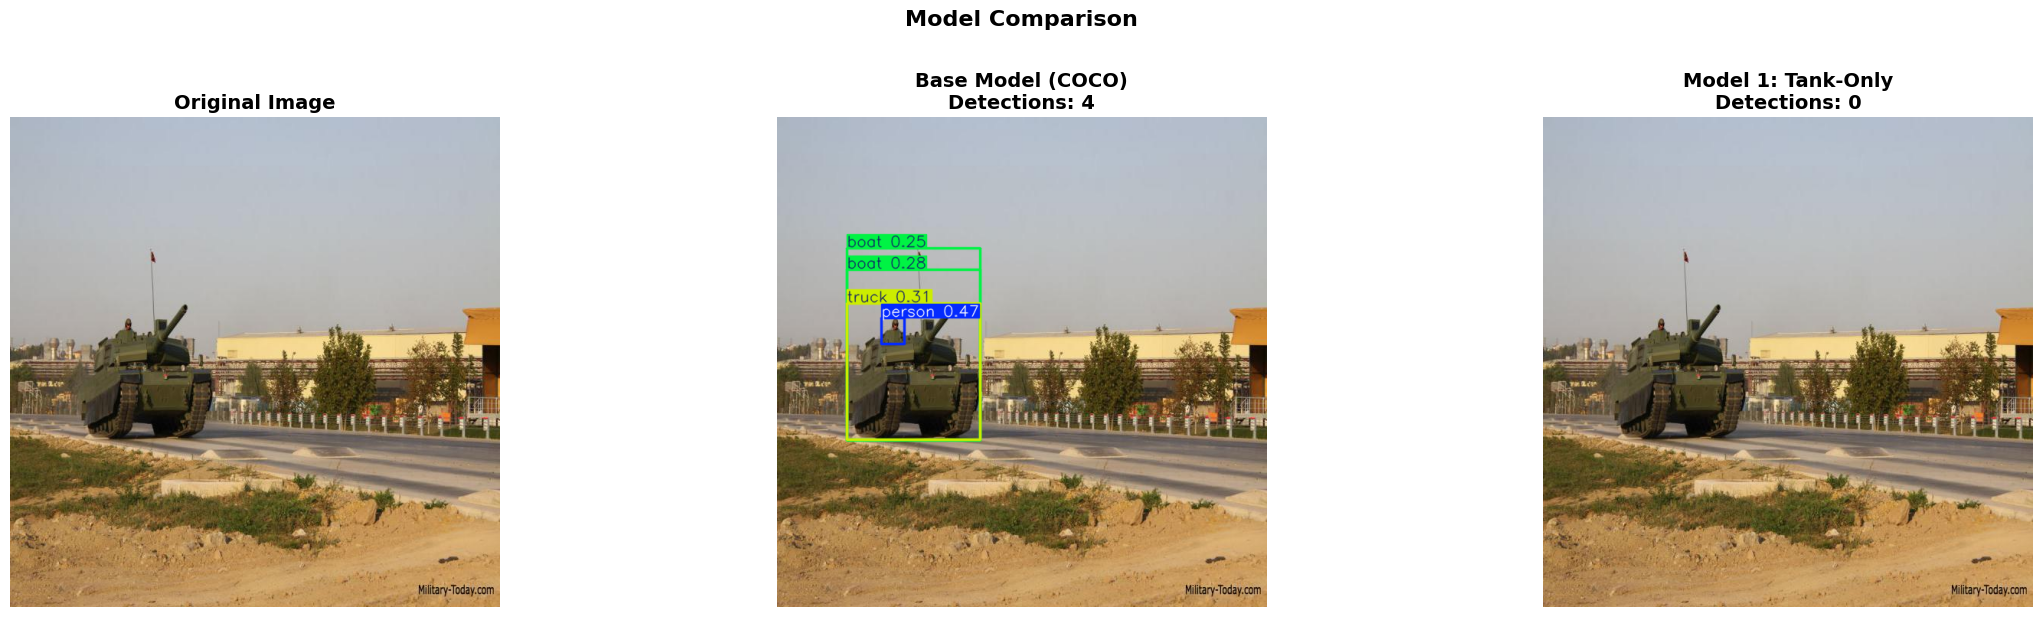


Image 2/13: tank_cv90105_l3_jpg.rf.6c07354202657f2810fc0689ec6d3c46.jpg

Base Model (COCO) - Detections
  Detection 1: person
    Confidence: 92.06%
    Bounding Box: [246.8, 306.0, 385.3, 639.8]
  Detection 2: person
    Confidence: 89.63%
    Bounding Box: [0.0, 338.2, 68.8, 640.0]
  Detection 3: person
    Confidence: 75.70%
    Bounding Box: [93.8, 362.1, 134.1, 524.0]
  Detection 4: tie
    Confidence: 35.13%
    Bounding Box: [13.4, 391.5, 26.5, 447.1]
  Detection 5: tie
    Confidence: 26.70%
    Bounding Box: [10.9, 390.5, 28.2, 473.7]

Model 1 (Tank-Only) - Detections
No objects detected


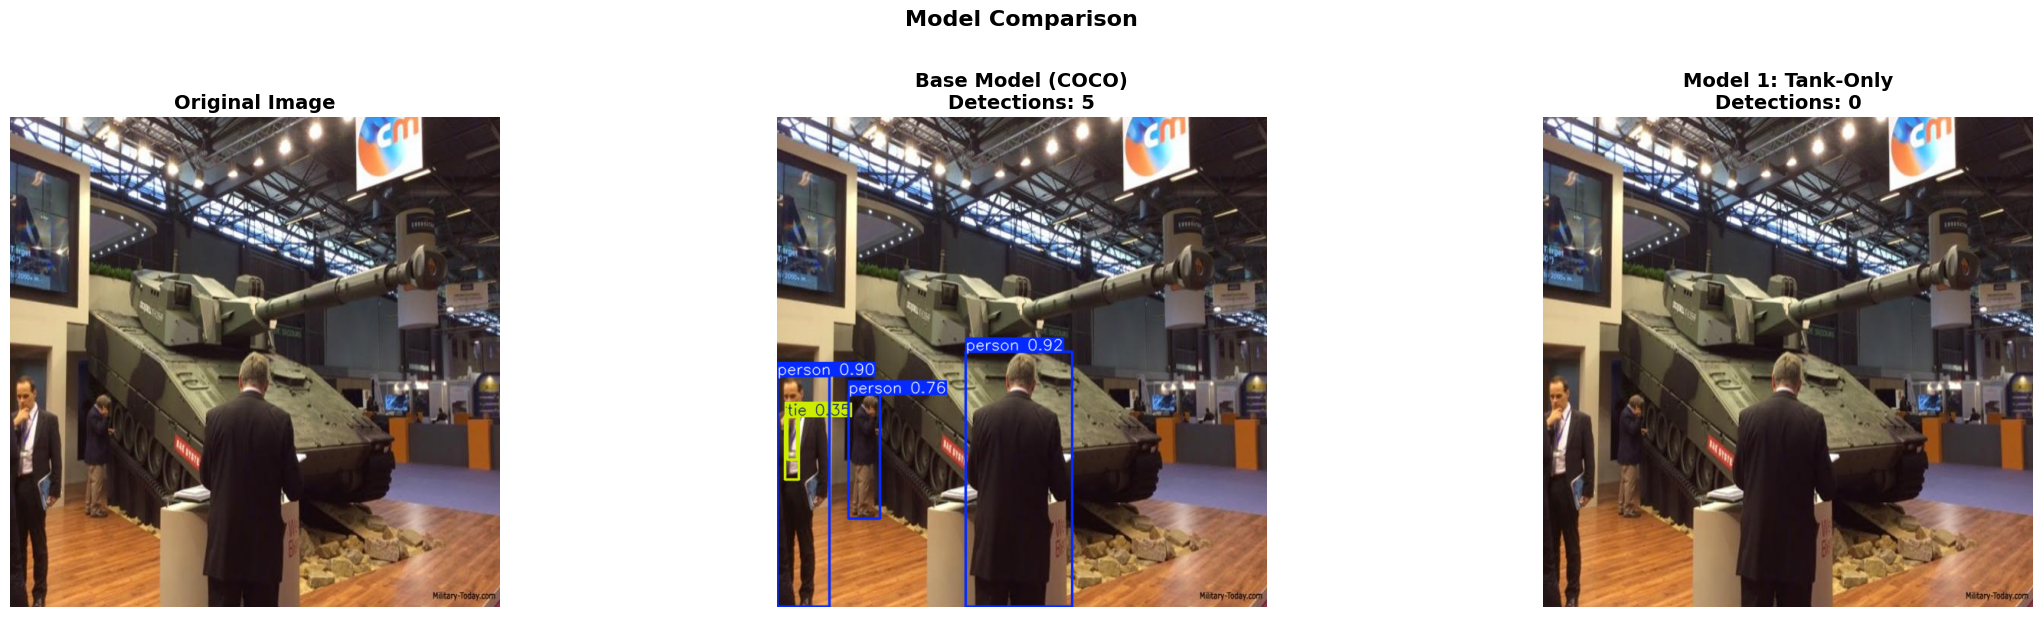


Image 3/13: tank_gl5_main_jpg.rf.e7ea30288dfb6b0da8627fdf3fb25fa7.jpg

Base Model (COCO) - Detections
  Detection 1: train
    Confidence: 48.58%
    Bounding Box: [1.2, 201.8, 579.1, 539.1]

Model 1 (Tank-Only) - Detections
No objects detected


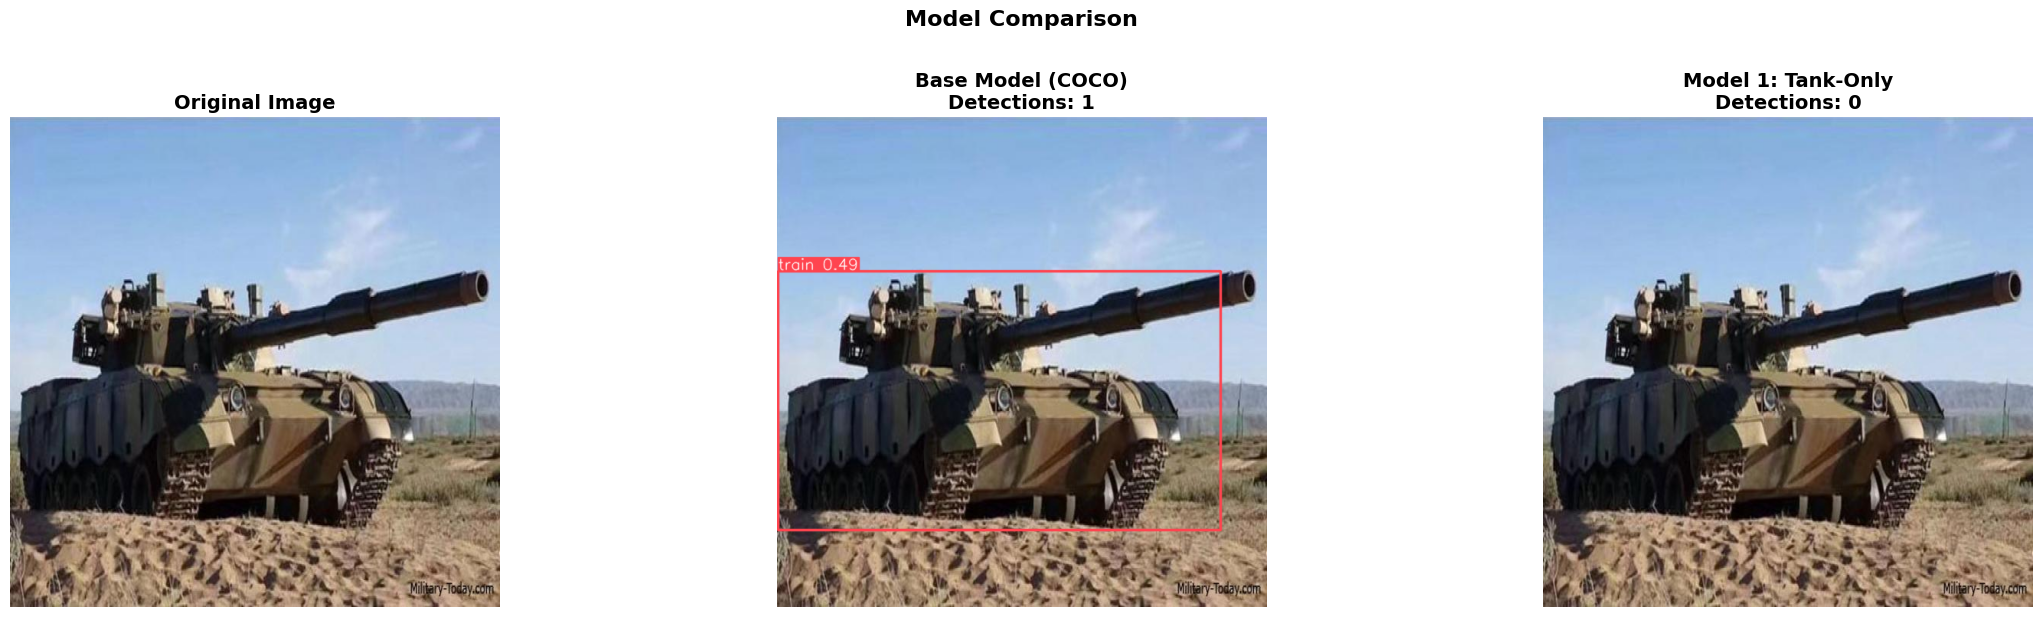


Image 4/13: tank_expeditionary_tank_l5_jpg.rf.283feb28dc52d2330dc7d554860b697b.jpg

Base Model (COCO) - Detections
  Detection 1: truck
    Confidence: 37.64%
    Bounding Box: [16.0, 341.8, 586.2, 584.9]
  Detection 2: truck
    Confidence: 25.84%
    Bounding Box: [13.5, 238.5, 593.6, 592.8]
  Detection 3: airplane
    Confidence: 25.23%
    Bounding Box: [13.8, 240.5, 589.1, 598.4]

Model 1 (Tank-Only) - Detections
No objects detected


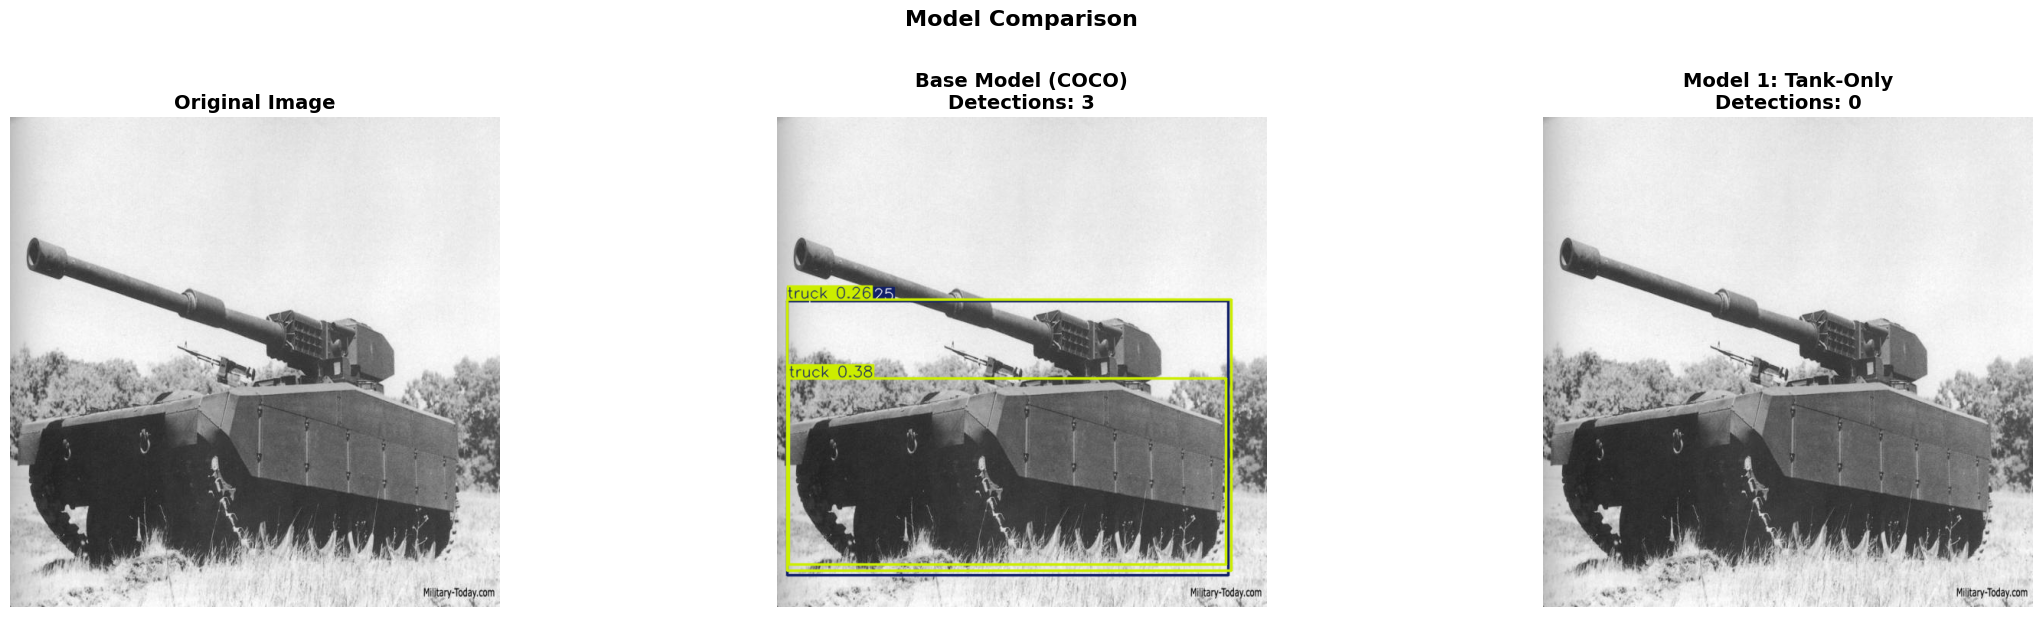


Image 5/13: tank_amx_13_main_jpg.rf.e48c07c9f1a7b5752d0e819cb6389731.jpg

Base Model (COCO) - Detections
  Detection 1: person
    Confidence: 80.61%
    Bounding Box: [394.8, 24.5, 483.5, 201.0]
  Detection 2: person
    Confidence: 68.59%
    Bounding Box: [285.7, 43.1, 381.4, 207.2]
  Detection 3: person
    Confidence: 31.46%
    Bounding Box: [118.8, 227.3, 206.2, 460.1]
  Detection 4: person
    Confidence: 27.10%
    Bounding Box: [120.3, 228.7, 204.6, 365.7]

Model 1 (Tank-Only) - Detections
No objects detected


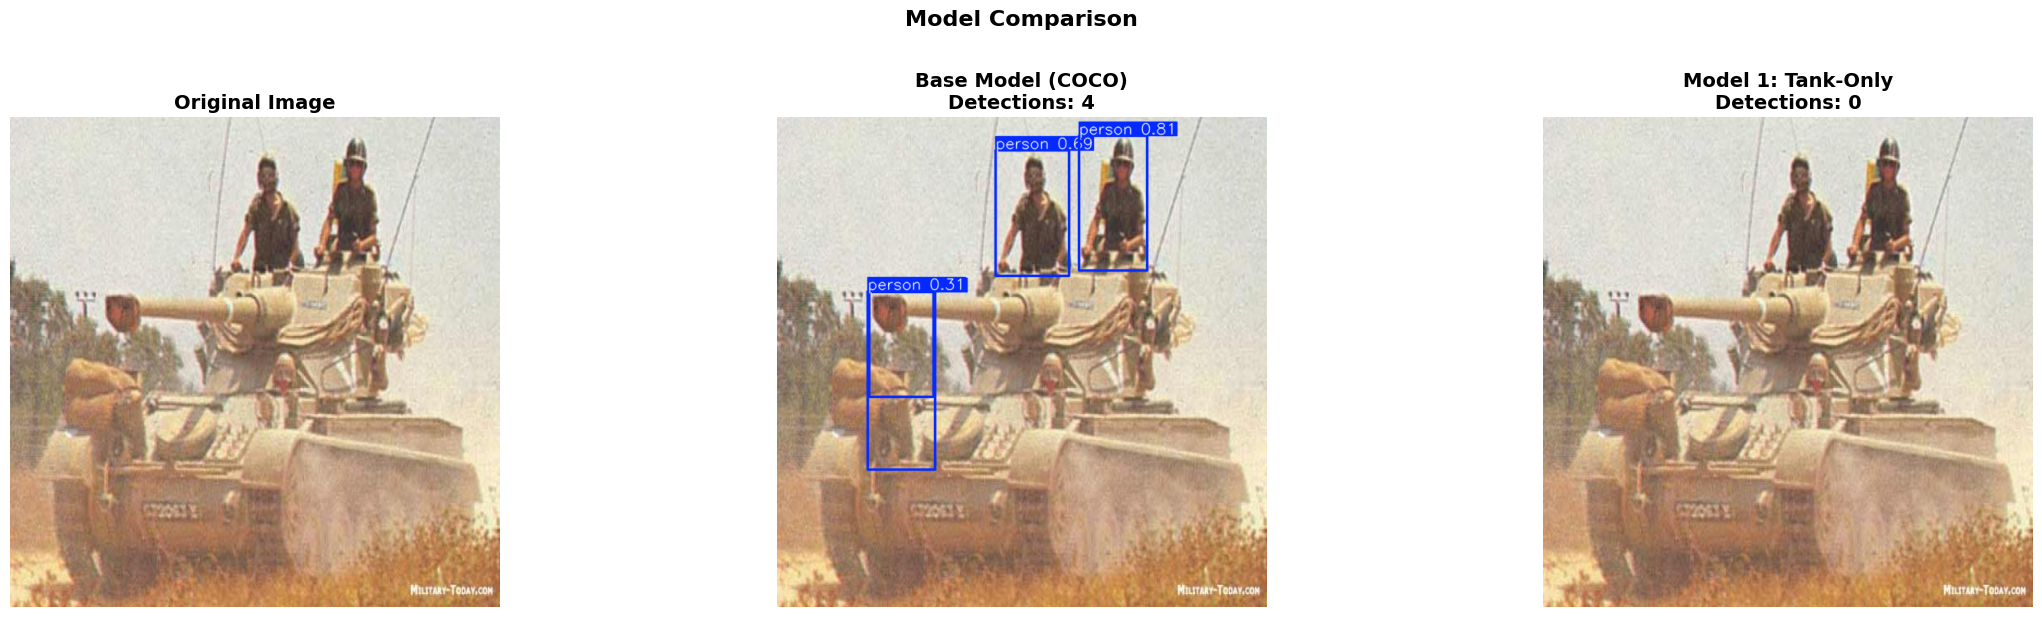


Image 6/13: tank_k1a1_l4_jpg.rf.47e7834bc38cc85195244fc71a03a290.jpg

Base Model (COCO) - Detections
  Detection 1: boat
    Confidence: 33.14%
    Bounding Box: [104.9, 196.7, 457.1, 455.1]

Model 1 (Tank-Only) - Detections
No objects detected


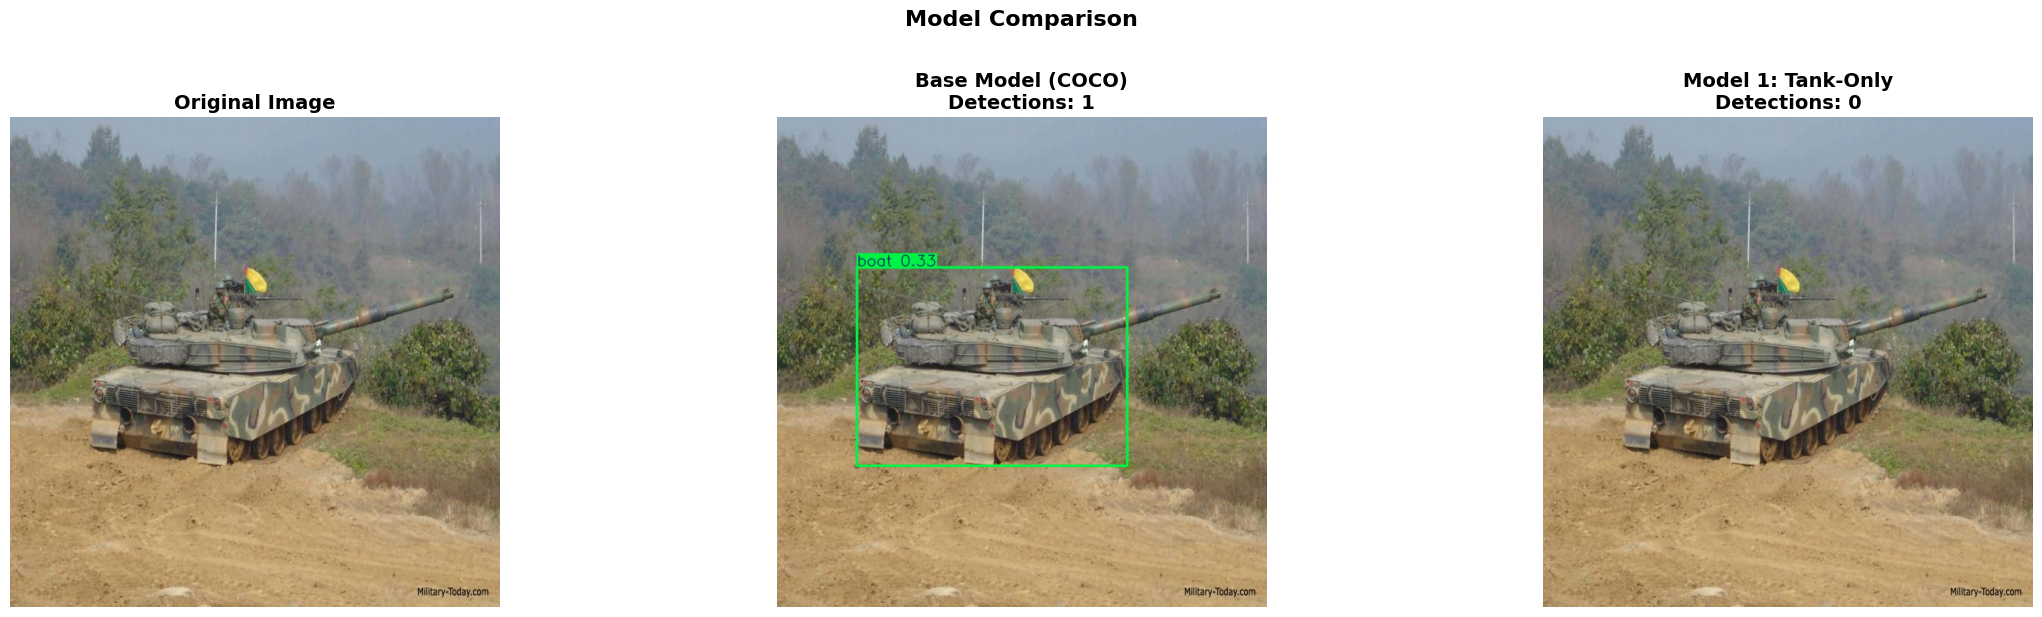


Image 7/13: tank_gl5_l1_jpg.rf.272fe1b528493f65dc00452ba3b1d8c2.jpg

Base Model (COCO) - Detections
  Detection 1: traffic light
    Confidence: 53.10%
    Bounding Box: [4.2, 47.8, 70.5, 185.5]
  Detection 2: train
    Confidence: 36.71%
    Bounding Box: [12.9, 23.6, 639.5, 640.0]

Model 1 (Tank-Only) - Detections
No objects detected


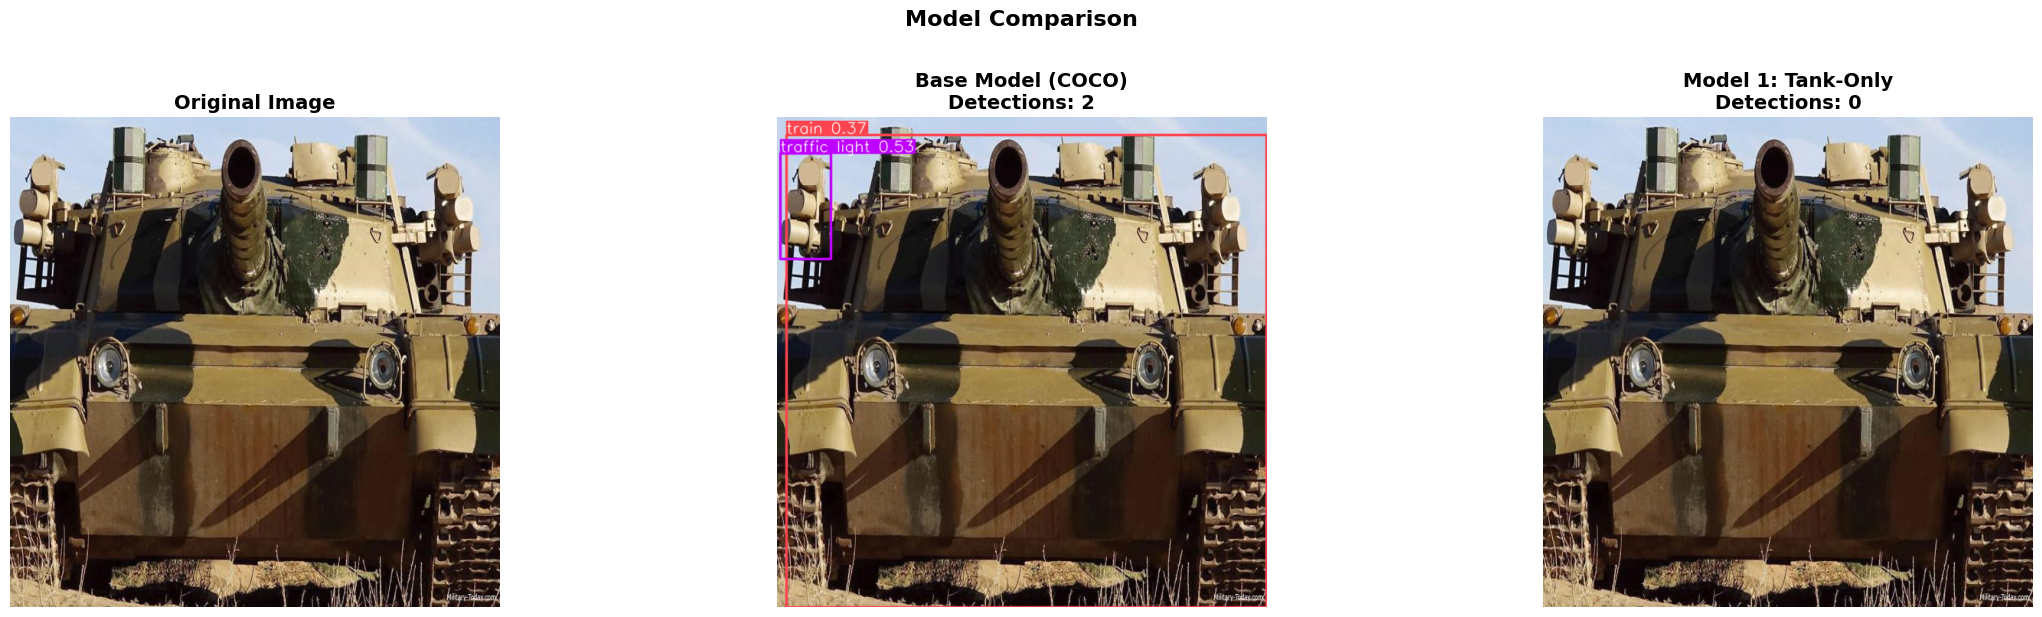


Image 8/13: tank_altay_main_jpg.rf.16552b8d1aac4227ec669801aa7b6503.jpg

Base Model (COCO) - Detections
  Detection 1: truck
    Confidence: 64.05%
    Bounding Box: [23.6, 37.7, 634.5, 592.4]
  Detection 2: traffic light
    Confidence: 45.95%
    Bounding Box: [188.7, 160.9, 198.9, 182.6]
  Detection 3: person
    Confidence: 30.18%
    Bounding Box: [321.0, 176.8, 472.8, 290.8]
  Detection 4: person
    Confidence: 25.79%
    Bounding Box: [147.9, 208.2, 208.0, 314.5]
  Detection 5: traffic light
    Confidence: 25.26%
    Bounding Box: [567.9, 303.8, 585.9, 347.4]

Model 1 (Tank-Only) - Detections
No objects detected


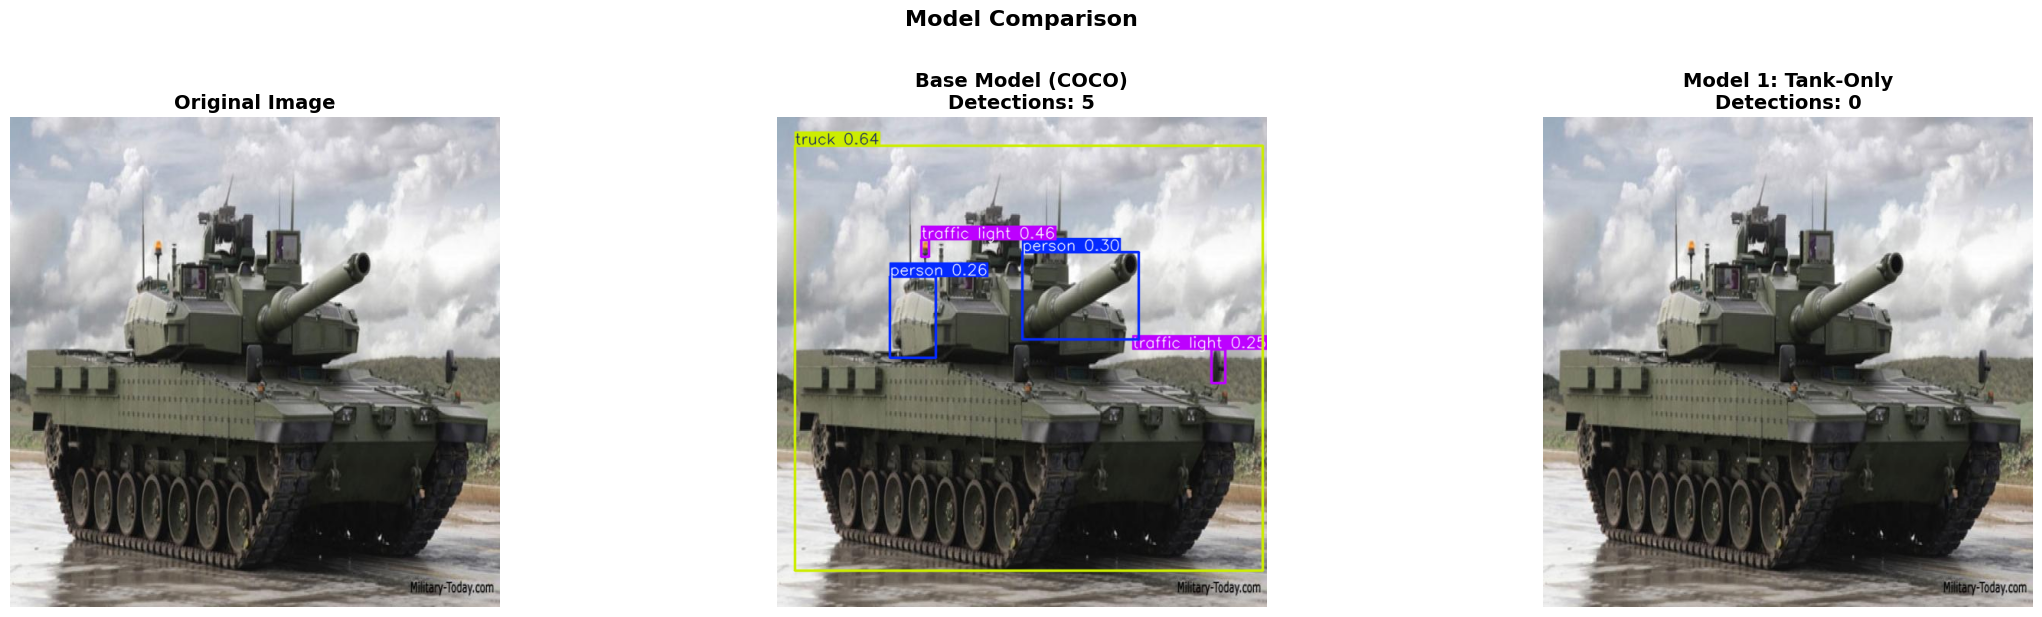


Image 9/13: tank_bmt_72_l5_jpg.rf.74f302d24af41686b068a405ca7efec4.jpg

Base Model (COCO) - Detections
  Detection 1: person
    Confidence: 87.20%
    Bounding Box: [508.2, 292.7, 575.6, 564.6]
  Detection 2: person
    Confidence: 86.42%
    Bounding Box: [248.6, 302.7, 316.3, 580.4]
  Detection 3: person
    Confidence: 85.84%
    Bounding Box: [172.1, 310.2, 250.7, 587.9]
  Detection 4: person
    Confidence: 85.68%
    Bounding Box: [11.6, 305.6, 106.1, 599.2]
  Detection 5: person
    Confidence: 84.93%
    Bounding Box: [437.7, 294.4, 509.9, 571.1]
  Detection 6: person
    Confidence: 83.94%
    Bounding Box: [369.7, 299.4, 432.4, 575.2]
  Detection 7: person
    Confidence: 83.44%
    Bounding Box: [101.4, 298.7, 173.7, 591.8]
  Detection 8: person
    Confidence: 77.53%
    Bounding Box: [314.5, 310.5, 376.9, 576.8]

Model 1 (Tank-Only) - Detections
No objects detected


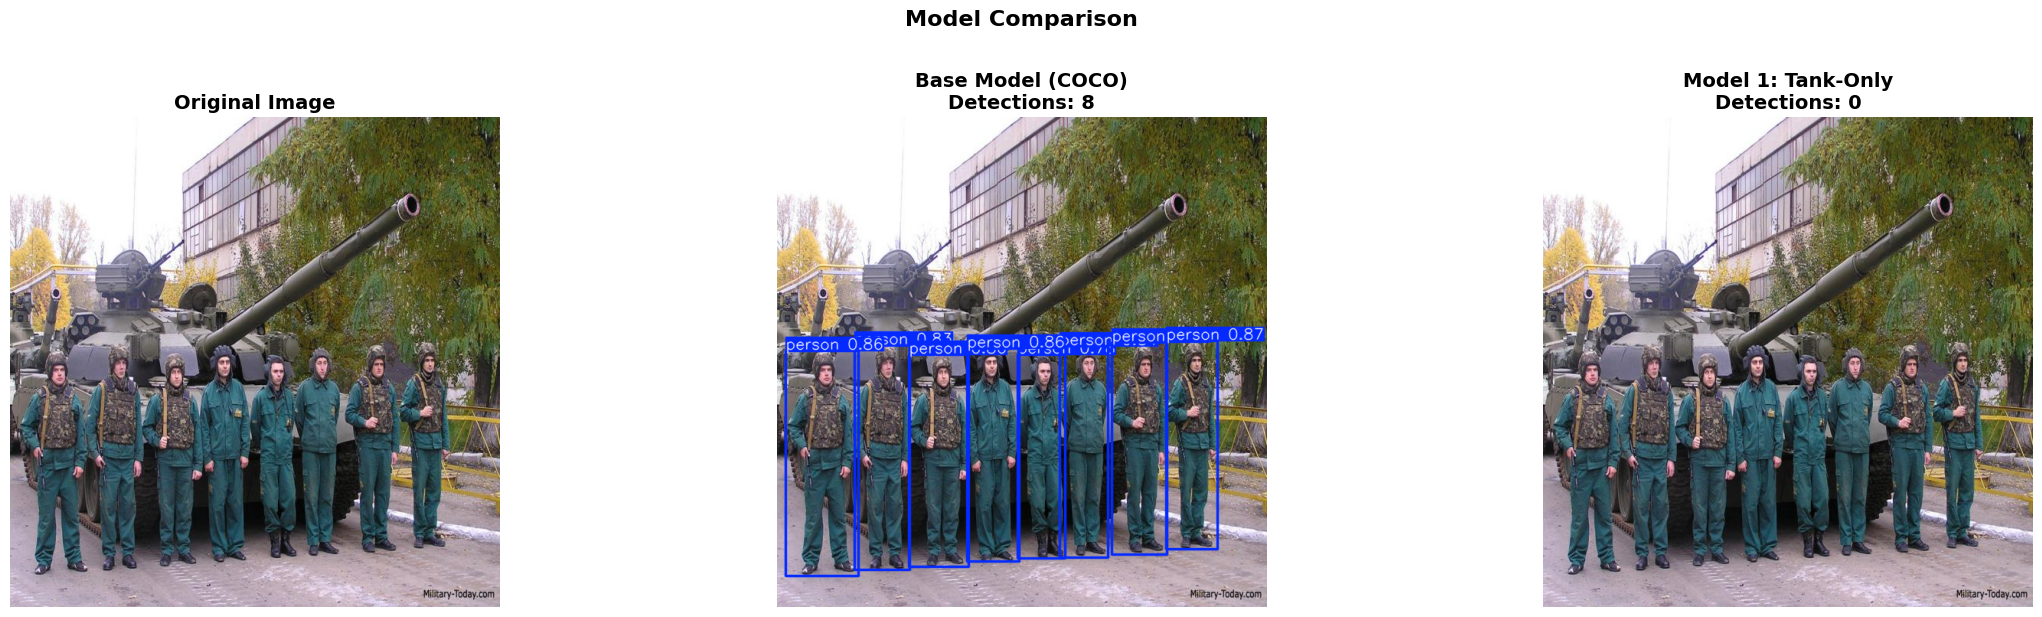


Image 10/13: tank_challenger_1_l10_jpg.rf.5e06cd05e9f5c8e9fbc8cc08e43bd19d.jpg

Base Model (COCO) - Detections
  Detection 1: person
    Confidence: 54.22%
    Bounding Box: [230.5, 89.0, 452.3, 263.1]

Model 1 (Tank-Only) - Detections
No objects detected


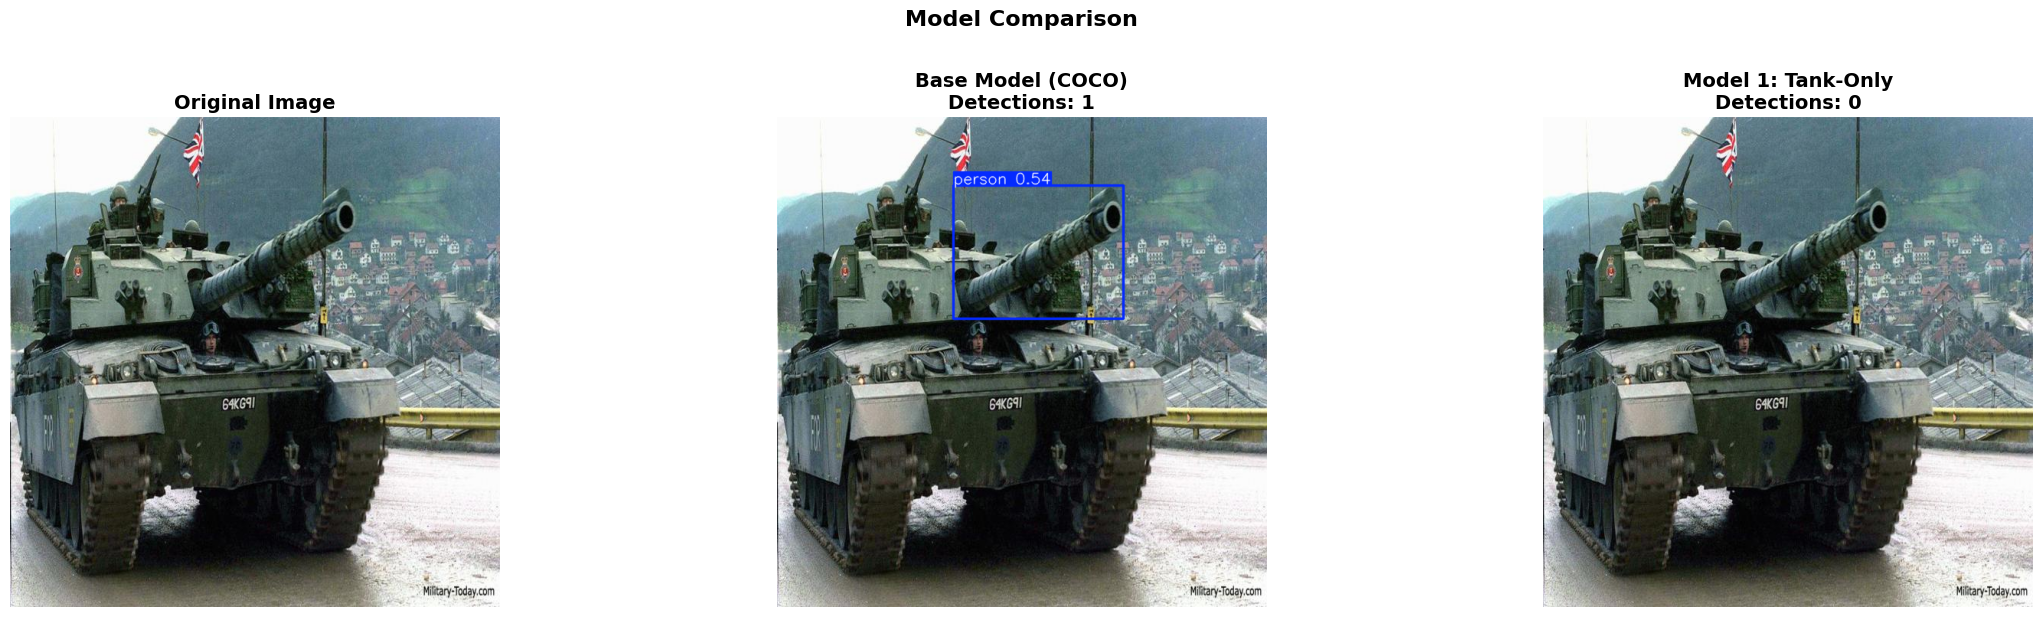


Image 11/13: tank_al_khalid_l2_jpg.rf.ff5f83f3a7419ebc588f54f62e735391.jpg

Base Model (COCO) - Detections
  Detection 1: train
    Confidence: 42.54%
    Bounding Box: [51.9, 345.8, 260.9, 620.3]
  Detection 2: giraffe
    Confidence: 36.42%
    Bounding Box: [255.5, 73.5, 485.3, 352.4]

Model 1 (Tank-Only) - Detections
No objects detected


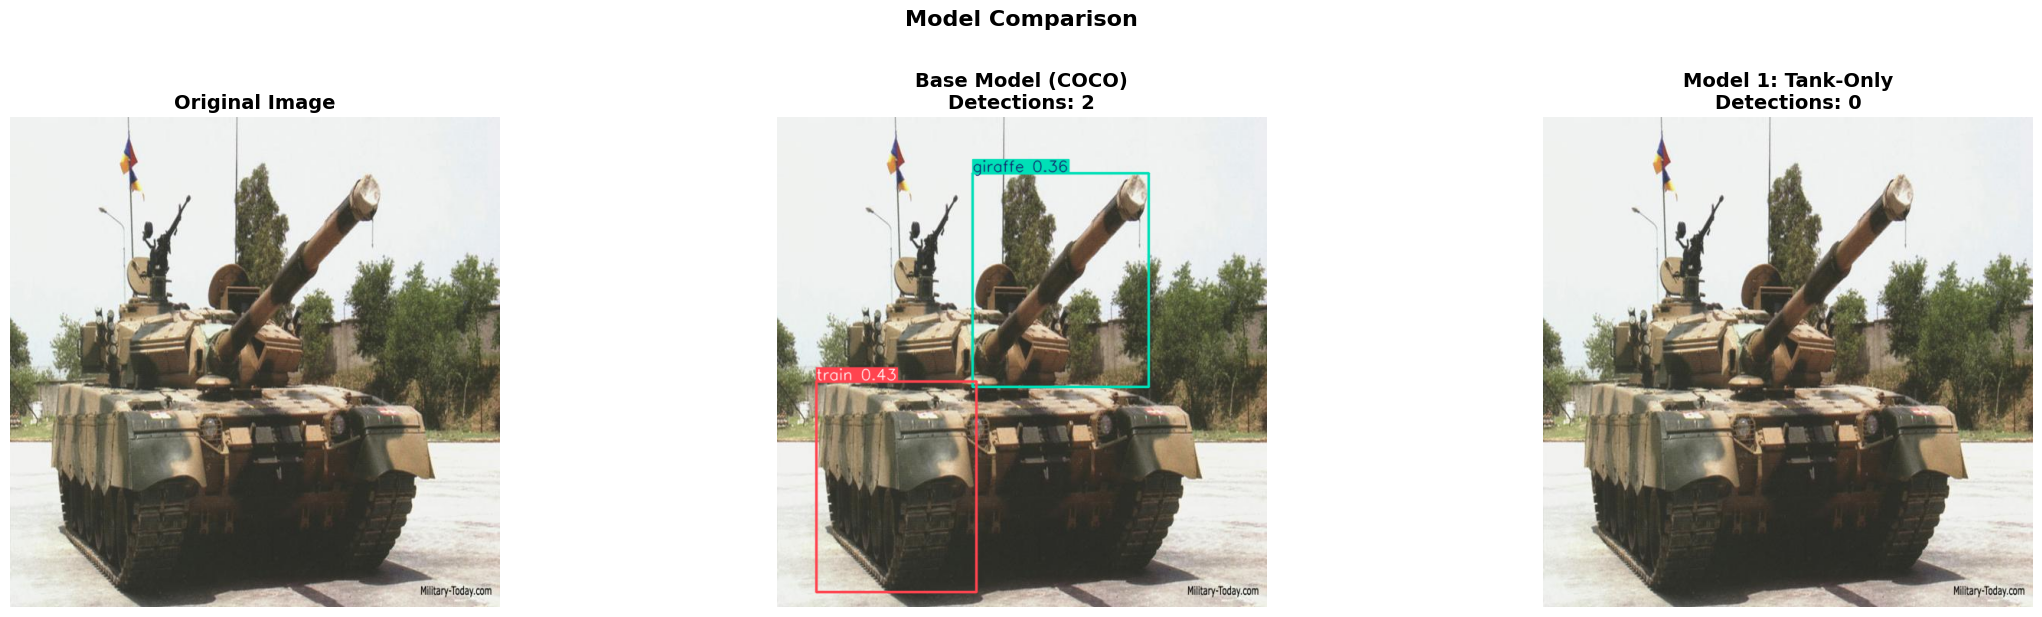


Image 12/13: tank_chieftain_main_jpg.rf.193af6dc0b29e844a20392ea3fada8d9.jpg

Base Model (COCO) - Detections
  Detection 1: train
    Confidence: 44.96%
    Bounding Box: [72.2, 97.1, 580.6, 542.5]

Model 1 (Tank-Only) - Detections
No objects detected


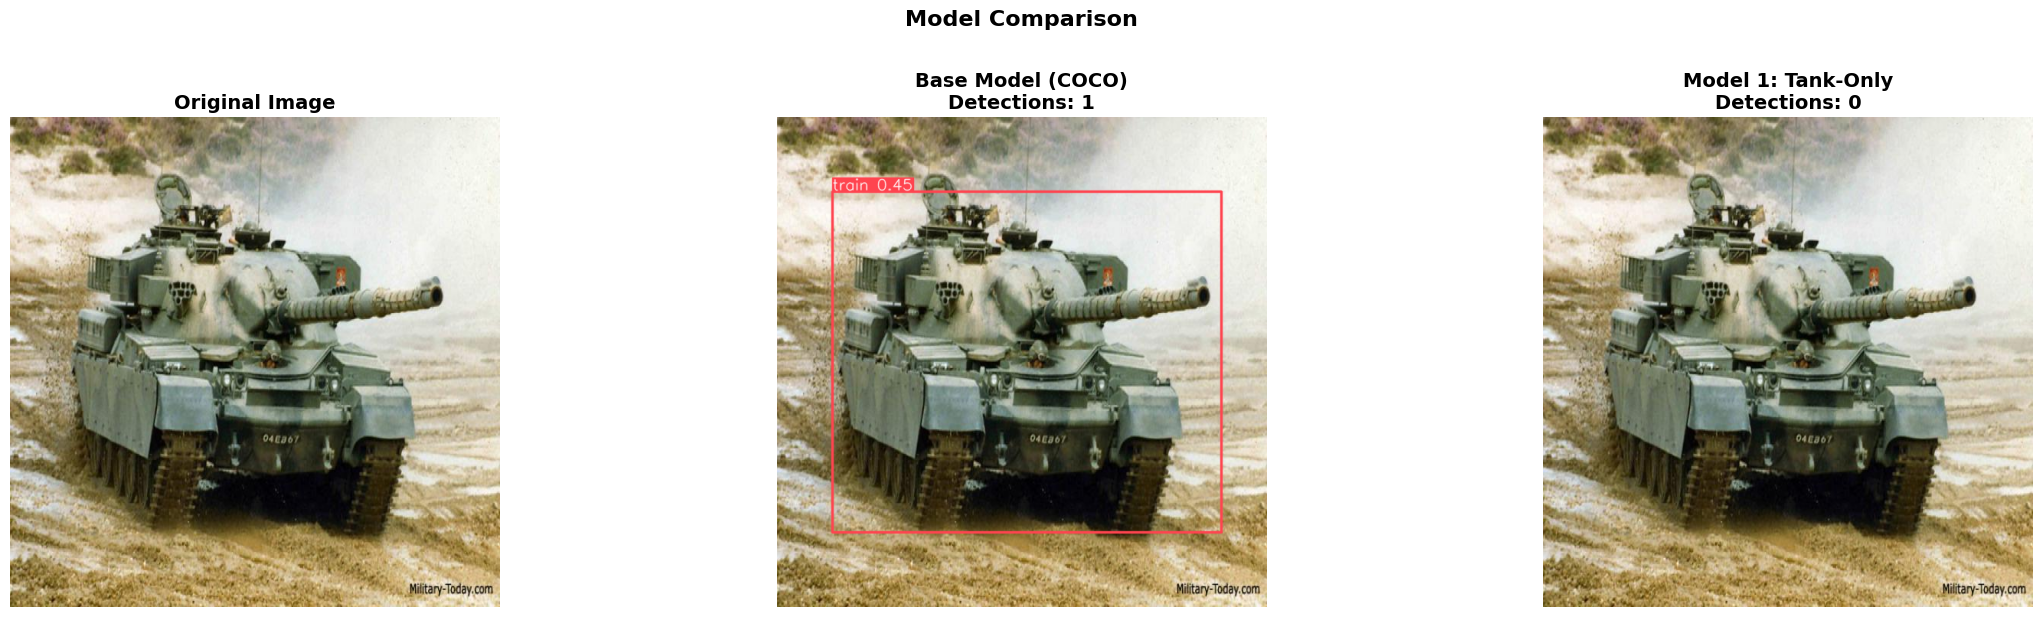


Image 13/13: tank_bmpt_l3_jpg.rf.33522eab13f35d8bb0385b24235f81cc.jpg

Base Model (COCO) - Detections
  Detection 1: person
    Confidence: 62.96%
    Bounding Box: [62.6, 277.0, 79.6, 321.1]
  Detection 2: truck
    Confidence: 62.15%
    Bounding Box: [33.7, 160.7, 585.6, 508.8]

Model 1 (Tank-Only) - Detections
No objects detected


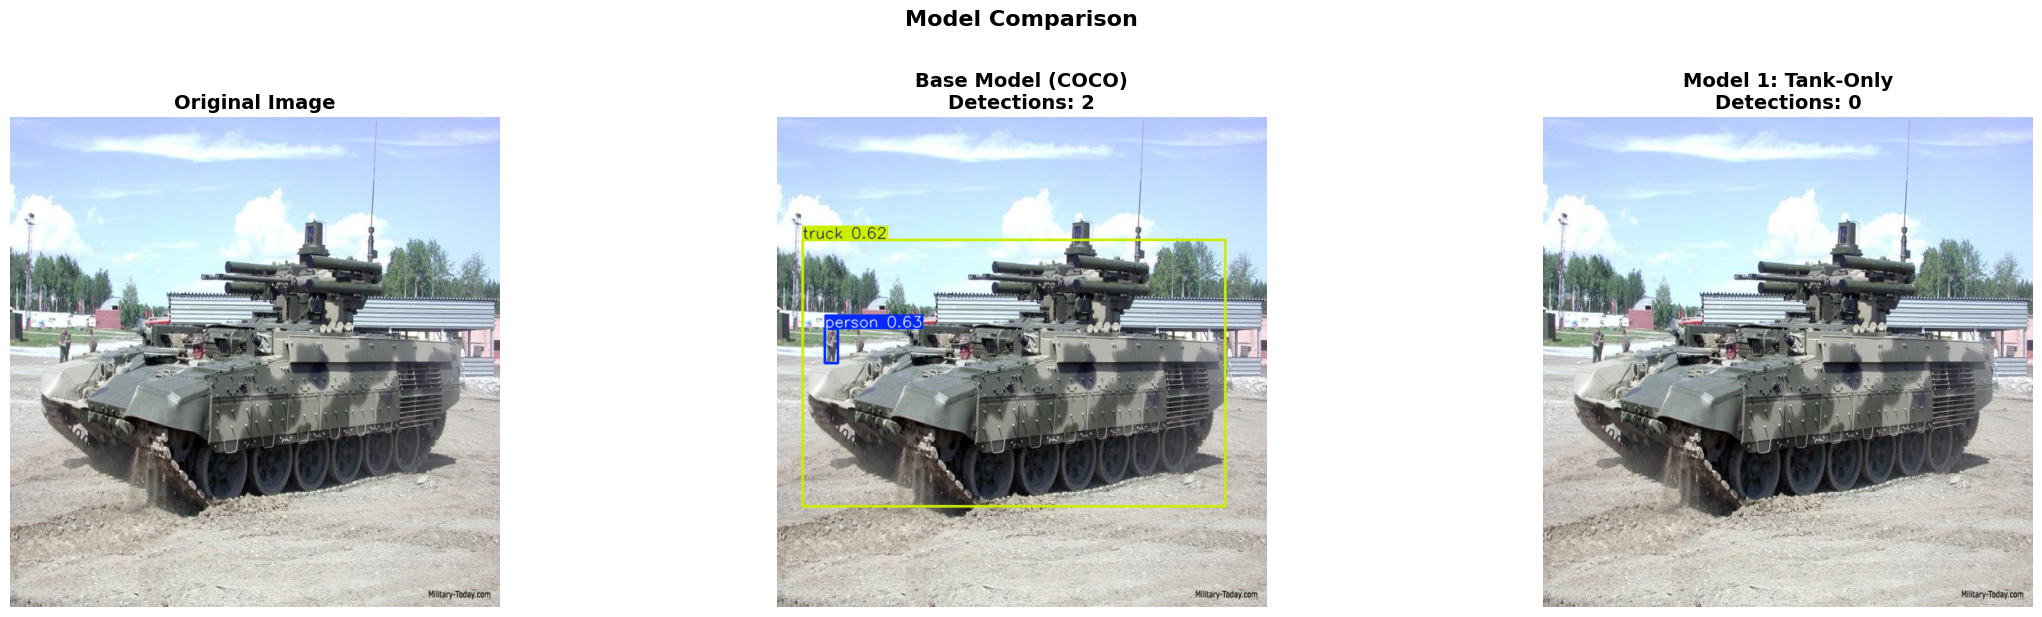

In [6]:
# Test on multiple tank images
test_images_dir = PROJECT_ROOT / "dataset_only_tank" / "test" / "images"
test_images = list(test_images_dir.glob("*.jpg"))[:13] if test_images_dir.exists() else []

if len(test_images) > 0:
    print(f"Testing on {len(test_images)} tank images from {test_images_dir.resolve()}...\n")
    
    for i, img_path in enumerate(test_images):
        print(f"\n{'='*80}")
        print(f"Image {i+1}/{len(test_images)}: {img_path.name}")
        print(f"{'='*80}")
        
        # Run inference with all three models
        results_base = base_model.predict(str(img_path), conf=0.25, verbose=False)
        results1 = model1.predict(str(img_path), conf=0.25, verbose=False)
        
        # Print details
        print_detection_details(results_base, "Base Model (COCO)")
        print_detection_details(results1, "Model 1 (Tank-Only)")
        
        # Plot comparison
        plot_comparison(str(img_path), results_base, results1)
else:
    print(f"⚠️  No test images found in {test_images_dir}")